##### 1.Исследование данных

In [ ]:
import pandas as pd
import re

PATH_TO_DATA = '/content/drive/MyDrive/ИАД/dataset_train.tsv'
LABELS_DESC_PATH = '/content/drive/MyDrive/ИАД/labels_description.txt'
DESC_PATTERN = '(\w+(?:\s+\w+)*)\s*-\s*(\w+(?:\s+\w+)*)'

def parse_labels_description(desc_path):
    """
    Эта функция парсит файлик с описанием интентов
    """
    with open(desc_path, 'r') as desc:
        pattern = re.compile(DESC_PATTERN)

        labels_descriptions = []
        for line in desc.readlines():
            labels_descriptions.append(re.findall(pattern, line)[0])

        labels_descriptions = pd.DataFrame(labels_descriptions, columns=['intent', 'desc'])
    return labels_descriptions

df = pd.read_csv(PATH_TO_DATA, delimiter='\t', encoding="utf-8", names=['text', 'intent'])
labels_descriptions = parse_labels_description(LABELS_DESC_PATH)
print("N интентов:" + str(labels_descriptions.shape[0]))


N интентов:141


In [ ]:
labels_descriptions

,intent,desc
0,statement_general,get a document of some undefined type
1,incomestat,get an income statement
2,conform,get a document that proofs that a person belon...
3,transcript,get a student transcript
4,loc_cafeteria_new_building_general,find a cafe in building
...,...,...
136,loc_pharm,find out a pharmacy
137,site_library,what is a site for the university library
138,student_union_event_guests,how a student union can invite guests
139,stat_numb_of_students,how many students there are in the university


In [ ]:
#Visual function
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

def plot_with_subplots(data, xlabel, ylabel, title):
    """
    Эта функция для отрисовки графиков
    """
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"colspan": 2}, None], [{}, {}]],
        subplot_titles=(title,"Head", "Tail")
    )
    
    data_head = data.head(10)
    data_tail = data.tail(10)

    bar_1 = go.Bar(y=data[xlabel], x=data.index)
    bar_2 = go.Bar(y=data_head[xlabel], x=data_head[ylabel])
    bar_3 = go.Bar(y=data_tail[xlabel], x=data_tail[ylabel])


    fig['layout']['xaxis2'].update(tickangle=-45)
    fig['layout']['xaxis3'].update(tickangle=-45)

    fig.add_trace(bar_1, row=1, col=1)
    fig.add_trace(bar_2, row=2, col=1)
    fig.add_trace(bar_3, row=2, col=2)

    fig.update_layout(showlegend=False)
    fig.show()

In [ ]:
intents_distribution = (
    df
    .groupby('intent', as_index=False)
    .agg(len)
    .sort_values(by='text', ascending=False)
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text': 'n_samples'})
)
plot_with_subplots(intents_distribution, 'n_samples', 'intent', 'Распределение интентов')

In [ ]:
mean_len_distribution = (
    df
    .assign(text_len = df.text.str.len())
    .groupby('intent', as_index=False)
    .text_len
    .agg("mean")
    .sort_values(by='text_len', ascending=False)
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text_len': 'mean_text_len'})
)
plot_with_subplots(mean_len_distribution, 'mean_text_len', 'intent', 'Распределение средних длин')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



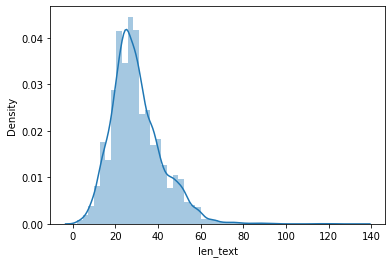

In [ ]:
df["len_text"] = df["text"].map(lambda x: len(x))
sns.distplot(df["len_text"])


In [ ]:
df[df["len_text"] <= 2]

,text,intent,len_text
1164,эф,loc_dean_ef,2
1422,ги,loc_dean_hi,2
2740,тц,loc_torgovy_center,2
4499,ты,smalltalk_skills,2
4527,ку,smalltalk_greetings,2
12789,со,studentorgs_define,2


##### 2.Подготовка данных для обучения

In [ ]:
#Аугументация
!pip install nlpaug
import nlpaug
import nlpaug.augmenter.word as naw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df.loc[ len(df.index )] = ["test", "smalltalk_abuse	", len("test")]

In [ ]:
need_shape = 800
aug = naw.SynonymAug(aug_src='wordnet',aug_max=2)

for intent in df.intent.unique():
  intent_df = df[df["intent"] == intent]
  len_intent = intent_df.shape[0]
  for i in range(need_shape - len_intent):
    for_aug = intent_df.sample(1).text.values[0]
    res = aug.augment(for_aug,n=2)[1]
    df.loc[ len(df.index )] = [res, intent, len(res)]
    

    
    
  


In [ ]:
intents_distribution = (
    df
    .groupby('intent', as_index=False)
    .agg(len)
    .sort_values(by='text', ascending=False)
    .merge(labels_descriptions, on='intent', how='left')
    .rename(columns={'text': 'n_samples'})
)
plot_with_subplots(intents_distribution, 'n_samples', 'intent', 'Распределение интентов')

In [ ]:
PATH_TO_DATA = '/content/drive/MyDrive/ИАД/file.csv'
#df.to_csv('file.csv')
df = pd.read_csv(PATH_TO_DATA)

In [ ]:
# Предвармтальная очистка
def clear_text(text):
    #Убираем символы длиной 1-2
    text = re.sub(r'\b\w{1,2}\b', '', text)
    #Меняем Ё на Е
    text = text.replace("ё", "е")
    #Убираем знаки пунктуации
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    text = text.translate(table)
    #Переводим в нижний регистр
    text = text.lower()
    #Убираем лишние пробелы
    text = " ".join(text.split())

    return text

df['text_processed'] = df['text'].map(lambda x: clear_text(x))

In [ ]:
# Лемматизация
!pip install pymorphy2
import pymorphy2
m = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    text = text.split(' ')
    lemm_text = list(map(lambda x: m.parse(x)[0].normal_form, text))
    return ' '.join(lemm_text)

df['text_processed'] = df['text_processed'].map(lambda x: lemmatization(x))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Стоп-слова
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")

df['text_processed'] = df['text_processed'].map(lambda x: x.split(' '))
df['text_processed'] = df['text_processed'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
df['text_processed'] = df['text_processed'].map(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import collections

def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
corpus = get_corpus(df['text_processed'])

counter = collections.Counter(corpus)
most_common = counter.most_common()
most_common[:10]

[('находиться', 12375),
 ('расположить', 11909),
 ('институт', 9428),
 ('деканат', 6792),
 ('корпус', 6757),
 ('распологаться', 5711),
 ('расписание', 5080),
 ('нгу', 4827),
 ('пропуск', 4534),
 ('общежитие', 4206)]

In [ ]:
#Saving process result
df.to_csv('after_process.csv')

##### 3.Сравнительный анализ моделей классификации

In [ ]:
PATH_TO_DATA_AFTER_AUG = '/content/drive/MyDrive/ИАД/file.csv'
df = pd.read_csv(PATH_TO_DATA_AFTER_AUG)

Разделим нашу выборку на выборки для валидации, обучения, тестированя

In [ ]:
from sklearn.model_selection import train_test_split

X = df.text.values
y = df.intent

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Воспользуемся популярным методом векторизации TF-IDF

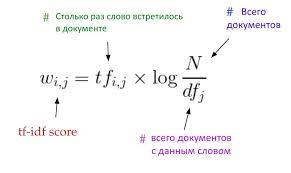

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/ИАД/tfidf.png', width=250, height=200)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_valid = vectorizer.transform(X_valid)

Закодируем наши целевые переменные численными значениями

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_valid = le.transform(y_valid)

Для обучения используем модели случайного леса и наивного байеса т.к. они имеют низкую трудоемкость в отличии от нейростевых алгоримтов и методов бэгинга, стикенга. А также хорошо показывают себя в задачах классификации текстов.

Начнем с модели случайного леса (ансамблевый метод)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

Будем искать подходящие гиперпараметры с помощью кросс-валидации

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [10, 50, 100, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 30, 100, 200],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_valid, y_valid)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 30, 100, 200],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 300]})

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 200,
 'max_features': 'log2',
 'n_estimators': 100}

In [ ]:
clf = RandomForestClassifier(max_depth=200, random_state=0, n_estimators=100, criterion = 'gini', max_features = 'log2')
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=200, max_features='log2', random_state=0)

In [ ]:
from sklearn.metrics import f1_score
prediction = clf.predict(X_test)
f1_score(y_test, prediction, average='micro')
#Micro?

0.9615197034724932

Также попробуем алгоритм наивного Байеса для многомерно распределенных данных, используемый в классификации текста (где данные обычно представляются в виде количества векторов слов, хотя векторы tf-idf также, как известно, хорошо работают на практике).

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'alpha': [0.001, 0.01, 0.1],
    'fit_prior': [True, False]
}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_valid, y_valid)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1],
                         'fit_prior': [True, False]})

In [ ]:

CV_rfc.best_params_

{'alpha': 0.001, 'fit_prior': False}

In [ ]:
clf = MultinomialNB(alpha = 0.001, fit_prior = True )
clf.fit(X_train, y_train)
#alpha?

MultinomialNB(alpha=0.001)

In [ ]:
from sklearn.metrics import f1_score
prediction = clf.predict(X_test)
f1_score(y_test, prediction, average='micro')

0.9397678501755755

Теперь проверим повлияла ли на точность предобработка

In [ ]:
PATH_TO_DATA_AFTER_PREPROCESS = '/content/drive/MyDrive/ИАД/after_process.csv'
df = pd.read_csv(PATH_TO_DATA_AFTER_PREPROCESS)
df = df.dropna()
#В процессе очистки данных получились нулевые записи

In [ ]:
X = df.text_processed.values
y = df.intent

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_valid = vectorizer.transform(X_valid)

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [10, 50, 100, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 30, 100, 200],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_valid, y_valid)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 30, 100, 200],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 300]})

In [ ]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 200,
 'max_features': 'log2',
 'n_estimators': 300}

In [ ]:
clf = RandomForestClassifier(max_depth=200, random_state=0, n_estimators=300, criterion = 'entropy', max_features = 'log2')
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=200, max_features='log2',
                       n_estimators=300, random_state=0)

In [ ]:
from sklearn.metrics import f1_score
prediction = clf.predict(X_test)
f1_score(y_test, prediction, average='micro')

0.9500562539744656

Баес

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'alpha': [0.001, 0.01, 0.1],
    'fit_prior': [True, False]
}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_valid, y_valid)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1],
                         'fit_prior': [True, False]})

In [ ]:
CV_rfc.best_params_

{'alpha': 0.001, 'fit_prior': True}

In [ ]:
clf = MultinomialNB(alpha = 0.001, fit_prior = True )
clf.fit(X_train, y_train)
#alpha?

MultinomialNB(alpha=0.001)

In [ ]:
from sklearn.metrics import f1_score
prediction = clf.predict(X_test)
f1_score(y_test, prediction, average='micro')

0.9204128552560779

Предобработка отрицательно сказалась на результатах обучения
Возможно используемые методы привели к разреженности матрицы TF-IDF
Поэтому будем использовать вариант без предобработки

In [ ]:
0.9615197034724932 - 0.9397678501755755

0.021751853296917645

Лучшая f мера у Случайного леса, но случайный лес более сложная модель чем наивный баес, имеет больше параметров и большую трудоемкость.
Модель случайного леса заняла около 800 мб а наивный байес 6.38 мб,а разница f1 score 0.02. Поэтому в итоговом продукте будем использовать модель наивного классификатора Баеса.

##### 4.Обучение классификатора

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf = MultinomialNB(alpha = 0.001, fit_prior = True )
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.001)

In [ ]:
from sklearn.metrics import f1_score
prediction = clf.predict(X_test)
f1_score(y_test, prediction, average='micro')

0.9397678501755755

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, prediction, average='micro')

(0.9397678501755755, 0.9397678501755755, 0.9397678501755755, None)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
c_martix = confusion_matrix(y_test, prediction)
print("Сумма элементов матрицы ошибок ", c_martix.sum()," из них всего ", c_martix.sum() - sum(list(np.diagonal(c_martix)))," не на диогонали" )

Сумма элементов матрицы ошибок  20504  из них всего  1235  не на диогонали


In [ ]:
1235/20504*100

6.02321498244245

Модель ошибается на ~6%

<Figure size 14400x14400 with 0 Axes>

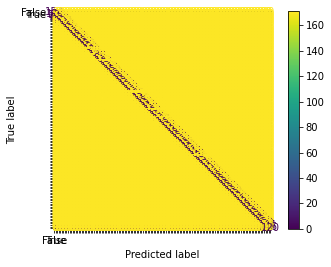

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from matplotlib.pyplot import figure

f = plt.figure()
f.set_figwidth(200)
f.set_figheight(200)


confusion_matrix = metrics.confusion_matrix(y_test, prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Сохранение модели

In [ ]:
import _pickle as cPickle

def save_model(model, filename):
    with open(filename, 'wb') as fid:
        cPickle.dump(model, fid)

def load_model(filename):
    with open(filename, 'rb') as fid:
        model = cPickle.load(fid)
    return model

In [ ]:
save_model(clf, './NB_classifier.pkl')
save_model(vectorizer, './vectorizer.pkl')
save_model(le, './le.pkl')

In [ ]:
df.len_text.mean()

29.713905715038187